In [1]:
%load_ext autoreload
%autoreload

In [2]:
from utils_v1 import *


In [3]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import tracemalloc
import sys
import numpy as np
from src.dataset import (
    MultipleDates,
    PAMultipleDates,
    MTMultipleDates,
    MAMultipleDates,
    MSMultipleDates,
    PIMultipleDates,
    MOMultipleDates,
    L8MTMultipleDates,
    L8AMMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates
from src.manager.multioutput import ManagerMCDropout, ManagerSingleRun, ManagerEnsemble, ManagerEvidential2
from src.Logger import Logger
import src.rasterTools as rasterTools



Tensorflow ver. 2.6.0


In [4]:
ic.configureOutput(includeContext=True)

In [5]:
useLessInferenceRuns = False
reducedInferenceRuns = 30

In [6]:
config = {
	"training": False,
	"inferring": True,
	"site": "PA", # values: MT, PA, MS, PI, L8MT, L8AM
	"training_date": "earlier", # values: earlier, current
	"mode": "ensemble", # values: mcd, single_run, ensemble, evidential2
	"uncertainty_method": "pred_entropy", # pred_var MI pred_entropy KL pred_entropy_single
	"loadInference": False,
	"removePolygons": True,
	"plotLandsat": False,
	"plotPOI": False,

	"save_probabilities": False,
	"addPastDeforestationInput": True,
	"classes_mode": False,
	"learning_rate": 1e-4,
    "use_cloud_mask": True,
    "mask_out_non_biome": False,
	# "mask_out_no_data": True


	"georreferenced_save": True,
	"drop_no_data_pixels": False,
	"use_entire_image_as_training": False

}

In [7]:



if config['mode'] == 'mcd':
	managerClass = ManagerMCDropout
	config['inference_times'] = 10
	config['training_times'] = 1
elif config['mode'] == 'single_run':
	managerClass = ManagerSingleRun
	config['inference_times'] = 1
	config['training_times'] = 1
	config['uncertainty_method'] = 'pred_entropy_single'
elif config['mode'] == 'ensemble':
	managerClass = ManagerEnsemble
	config['inference_times'] = 10
	config['training_times'] = 10
elif config['mode'] == 'evidential2':
	managerClass = ManagerEvidential2
	config['inference_times'] = 1
	config['training_times'] = 1
else:
	raise ValueError('Invalid mode')

print(config)

if config['site'] == 'PA':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2017, 2018]
	else:
		dates = [2018, 2019]
	datasetClass = PAMultipleDates
elif config['site'] == 'MT':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2018, 2019]
	else:
		dates = [2019, 2020]
	datasetClass = MTMultipleDates
elif config['site'] == 'MS':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2018, 2019]
		# dates = [2019, 2020]

	else:
		dates = [2019, 2020]
		# dates = [2020, 2021]

	datasetClass = MSMultipleDates
elif config['site'] == 'PI':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2018, 2019]
		# dates = [2017, 2018]

	else:
		dates = [2019, 2020]
		# dates = [2018, 2019]

	datasetClass = PIMultipleDates
	config['mask_out_non_biome'] = True
elif config['site'] == 'MO':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2018, 2019]
	else:
		dates = [2019, 2020]
	datasetClass = MOMultipleDates
elif config['site'] == 'L8MT':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2021, 2022]
	else:
		dates = [2022, 2023]
		# dates = [2021, 2022]
	datasetClass = L8MTMultipleDates
elif config['site'] == 'L8AM':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2021, 2022]
	else:
		dates = [2022, 2023]
	datasetClass = L8AMMultipleDates

else:
	raise ValueError('Invalid site')

dataset = datasetClass(config = config,
			   dates = dates, 
	 	addPastDeforestationInput = config['addPastDeforestationInput'],
		borderBuffer = 2)	

if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)
else:
	patchesHandler = PatchesHandler()



if config['training'] == False:

	if type(dataset) == PAMultipleDates:


		if config['training_date'] == 'current': exp = 0; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			exp = 1; repetition_id = 0
			# exp = 20; repetition_id = 0
		 
	elif type(dataset) == MTMultipleDates:
		
		if config['training_date'] == 'current': exp = 2; repetition_id = 8
		elif config['training_date'] == 'earlier': exp = 3; repetition_id = 6		

	elif type(dataset) == MSMultipleDates:

		if config['training_date'] == 'current': exp = 40; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			# exp = 5; repetition_id = 0		
			# exp = 24; repetition_id = 0	
			# exp = 30; repetition_id = 0	# L1C
			exp = 37; repetition_id = 0	# L1C (New)
			
	elif type(dataset) == PIMultipleDates:

		if config['training_date'] == 'current': exp = 6; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			exp = 7; repetition_id = 0	
			## exp = 18; repetition_id = 0	
			exp = 27; repetition_id = 0 # L1C
			# exp = 28; repetition_id = 0 # L1C 2020
	elif type(dataset) == MOMultipleDates:

		if config['training_date'] == 'current': exp = 6; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			exp = 7; repetition_id = 0	
			exp = 19; repetition_id = 0	
	elif type(dataset) == L8MTMultipleDates:

		if config['training_date'] == 'current': exp = 38; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			
			exp = 38; repetition_id = 0	
	elif type(dataset) == L8AMMultipleDates:

		if config['training_date'] == 'current': exp = 38; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			
			exp = 39; repetition_id = 0	

else:

	exp = 39
	repetition_id = 0
	
logger = Logger()
manager = managerClass(config, dataset, patchesHandler, logger)
manager.defineExperiment(exp)


{'training': False, 'inferring': True, 'site': 'PA', 'training_date': 'earlier', 'mode': 'ensemble', 'uncertainty_method': 'pred_entropy', 'loadInference': False, 'removePolygons': True, 'plotLandsat': False, 'plotPOI': False, 'save_probabilities': False, 'addPastDeforestationInput': True, 'classes_mode': False, 'learning_rate': 0.0001, 'use_cloud_mask': True, 'mask_out_non_biome': False, 'georreferenced_save': True, 'drop_no_data_pixels': False, 'use_entire_image_as_training': False, 'inference_times': 10, 'training_times': 10}


ic| dataset.py:608 in __init__()- list(self.date_ids): [0]
ic| dataset.py:629 in __init__()
    self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| patchesHandler.py:166 in __init__()- self.input_image_shape: 21
ic| patchesHandler.py:167 in __init__()
    self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [8]:
'''
import src.Logger as lg
importlib.reload(lg)
logger = Logger()
manager.logger = logger
'''

'\nimport src.Logger as lg\nimportlib.reload(lg)\nlogger = Logger()\nmanager.logger = logger\n'

In [9]:
dates

[2018, 2019]

In [10]:
manager.config

{'training': False,
 'inferring': True,
 'site': 'PA',
 'training_date': 'earlier',
 'mode': 'ensemble',
 'uncertainty_method': 'pred_entropy',
 'loadInference': False,
 'removePolygons': True,
 'plotLandsat': False,
 'plotPOI': False,
 'save_probabilities': False,
 'addPastDeforestationInput': True,
 'classes_mode': False,
 'learning_rate': 0.0001,
 'use_cloud_mask': True,
 'mask_out_non_biome': False,
 'georreferenced_save': True,
 'drop_no_data_pixels': False,
 'use_entire_image_as_training': False,
 'inference_times': 10,
 'training_times': 10,
 'dropout_training': False}

In [11]:
exp

1

In [12]:
manager.setExperimentPath()
manager.createLogFolders()

In [13]:
# ic(type(dataset), exp, dataset.dates)


In [14]:

manager.loadLabel()

D:/Jorge/datasets/deforestation/PA/deforestation_past_years.tif
Loaded deforestation past years


ic| dataset.py:706 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| dataset.py:709 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| dataset.py:713 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/PA/deforestation_before_2008_PA.tif


ic| dataset.py:717 in loadLabelFromDate()
    np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| dataset.py:719 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| dataset.py:698 in loadLabel()
    label_per_date.shape: (17730, 9203, 1)


Removing bufer................
Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]


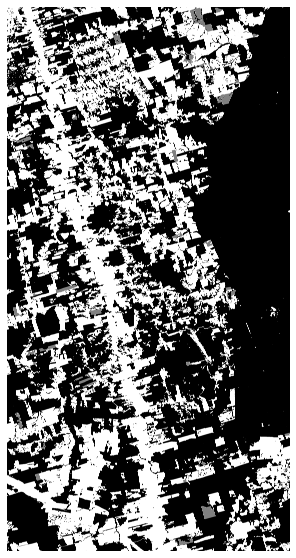

In [15]:
manager.logger.plotFigure(manager.label_mask, 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

In [16]:

# Creating tile mask
manager.createTrainValTestTiles()


Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [17]:
def get_pixel_count_set(label, mask, set_id):
    label_set = label[mask == set_id]
    return np.unique(label_set, return_counts=True)


In [18]:

np.unique(manager.mask_tiles)
for set_id in np.unique(manager.mask_tiles):
    print('Set', set_id, get_pixel_count_set(manager.label_mask, manager.mask_tiles, set_id))


Set 1 (array([0, 1, 2], dtype=uint8), array([3848933,   24058, 4282809], dtype=int64))
Set 2 (array([0, 1, 2], dtype=uint8), array([3946794,  155444, 4053562], dtype=int64))
Set 3 (array([0, 1, 2], dtype=uint8), array([3763825,  334071, 4057904], dtype=int64))
Set 4 (array([0, 1, 2], dtype=uint8), array([6200673,  140180, 1814947], dtype=int64))
Set 5 (array([0, 1, 2], dtype=uint8), array([3907717,   93438, 4154645], dtype=int64))
Set 6 (array([0, 1, 2], dtype=uint8), array([4353232,   51100, 3751468], dtype=int64))
Set 7 (array([0, 1, 2], dtype=uint8), array([4994674,   64045, 3097081], dtype=int64))
Set 8 (array([0, 2], dtype=uint8), array([8144807,   10993], dtype=int64))
Set 9 (array([0, 1, 2], dtype=uint8), array([5157160,  137968, 2860672], dtype=int64))
Set 10 (array([0, 1, 2], dtype=uint8), array([3475674,   83519, 4596607], dtype=int64))
Set 11 (array([0, 1, 2], dtype=uint8), array([4649101,  107494, 3399205], dtype=int64))
Set 12 (array([0, 1, 2], dtype=uint8), array([7750220

In [19]:

manager.label_mask.dtype

dtype('uint8')

In [20]:

manager.getLabelCurrentDeforestation()

In [21]:

manager.loadInputImage()

ic| dataset.py:649 in loadInputImage()
    image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)


In [22]:
if config['drop_no_data_pixels'] == True:
    manager.maskNoDataAsNotConsideredClass()

In [23]:
manager.dataset.previewBandsSnip

[[1, 2, 3], [11, 12, 13]]

In [24]:
condition = np.squeeze(np.zeros_like(manager.label_mask))


In [25]:
condition.shape

(17730, 9200)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


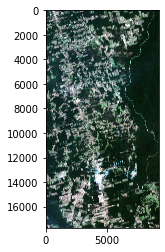

In [26]:
plt.imshow(manager.image_stack[...,[3,2,1]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


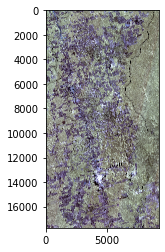

In [27]:
plt.imshow(manager.image_stack[...,[7,6,5]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


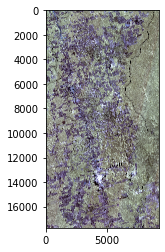

In [28]:
plt.imshow(manager.image_stack[...,[7,6,5]])

In [29]:

np.unique(manager.image_stack[...,0], return_counts=True)

(array([0.        , 0.08333334, 0.16666667, 0.25      , 0.33333334,
        0.4166667 , 0.5       , 0.5833334 , 0.6666667 , 0.75      ,
        0.8333334 , 0.9166667 , 1.        ], dtype=float32),
 array([104050616,   2209014,    644713,    968315,   1458862,   1560879,
          2477424,   1299508,    903419,    864429,   4570932,   3150455,
         38957434], dtype=int64))

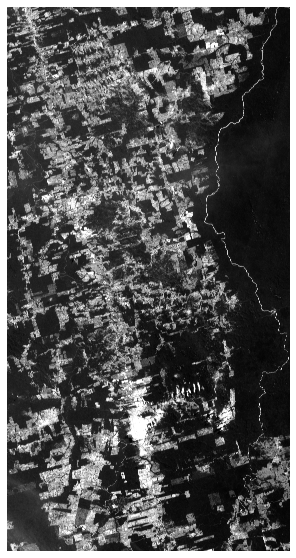

In [30]:

manager.logger.plotFigure(manager.image_stack[...,1], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

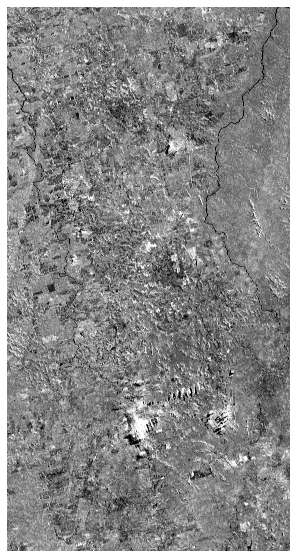

In [31]:

manager.logger.plotFigure(manager.image_stack[...,5], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

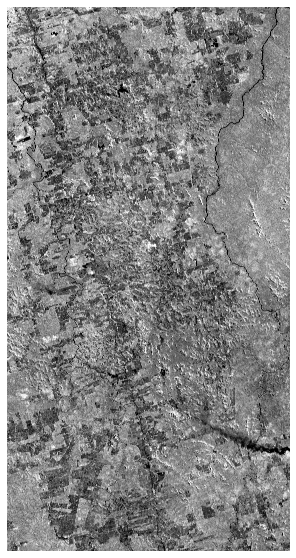

In [32]:

manager.logger.plotFigure(manager.image_stack[...,-3], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

In [33]:
def save_georreferenced(im, original_im_path, produced_im_path, bands = 1, plot = False):
    if len(im.shape) == 2:
        pad_values = ((0, 0), (0, 1))
    else:
        pad_values = ((0, 0), (0, 1), (0, 0))
    im_pad = np.pad(im, pad_values)
    print("im_pad.shape", im_pad.shape)

    if plot == True:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(im_pad, cmap='jet')
        plt.axis('off')

    if len(im_pad.shape) == 2:
        im_pad = np.expand_dims(im_pad, axis=0)
    else:
        im_pad = np.transpose(im_pad, (2, 0, 1))
    print("im_pad.shape", im_pad.shape)

    rasterTools.GeoReference_Raster_from_Source_data(original_im_path, 
                    im_pad.astype(np.float32), produced_im_path, bands = bands,
                    nodata=-1)
    del im_pad

In [34]:
import utils_v1
import rasterio

if config['georreferenced_save'] == True:
    # georref_im = utils_v1.load_tiff_image('D:/Jorge/datasets/sentinel2/MT_2019/S2_R1_MT_2019_08_02_2019_08_05_B3_B4.tif')
    original_im_path = os.path.join(manager.dataset.paths.optical_im_past_dates[dates[1]], 
        manager.dataset.paths.im_filenames[dates[1]][0])
    print("path",original_im_path)
    georref_im = utils_v1.load_tiff_image(original_im_path)

    print("georref_im.shape", georref_im.shape)

    del georref_im

path D:/Jorge/datasets/sentinel2/PA/2019\COPERNICUS_S2_20190721_20190726_B1_B2_B3.tif
D:/Jorge/datasets/sentinel2/PA/2019\COPERNICUS_S2_20190721_20190726_B1_B2_B3.tif
georref_im.shape (3, 17730, 9203)


In [35]:
if config['georreferenced_save'] == True:

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_sentinel2_{}_rgb_georreferenced.tif'.format(
        manager.dataset.site, dates[0])
    print(produced_im_path)
    bands = manager.dataset.previewBandsSnip[0]
    save_georreferenced(manager.image_stack[...,bands], original_im_path, produced_im_path, bands = 3)

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_sentinel2_{}_rgb_georreferenced.tif'.format(
        manager.dataset.site, dates[1])
    print(produced_im_path)
    bands = manager.dataset.previewBandsSnip[1]
    save_georreferenced(manager.image_stack[...,bands], original_im_path, produced_im_path, bands = 3)


D:/Jorge/deforestation_uncertainty/georreferenced/PA_sentinel2_2018_rgb_georreferenced.tif
im_pad.shape (17730, 9201, 3)
im_pad.shape (3, 17730, 9201)
D:/Jorge/deforestation_uncertainty/georreferenced/PA_sentinel2_2019_rgb_georreferenced.tif
im_pad.shape (17730, 9201, 3)
im_pad.shape (3, 17730, 9201)


In [36]:
np.unique(manager.label_mask, return_counts=True)

(array([0, 1, 2], dtype=uint8),
 array([100903598,   1838508,  60373894], dtype=int64))

In [37]:
# manager.maskNoDataAsNotConsideredClass()

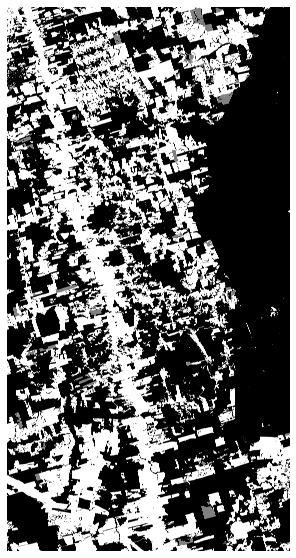

In [38]:

manager.logger.plotFigure(manager.label_mask, 
    name='label_mask', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

In [39]:

manager.getImageChannels()

ic| base.py:149 in getImageChannels()
    self.image_stack.shape: (17730, 9200, 21)
ic| base.py:151 in getImageChannels()- self.channels: 21


In [40]:

manager.getTrainValTestMasks()

Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [41]:
if config['use_entire_image_as_training'] == True:
    manager.mask_train_val[manager.mask_train_val == 0] = 1 # convert all test areas to train
    manager.mask_test[manager.mask_test == 1] = 0 # convert all test areas to train

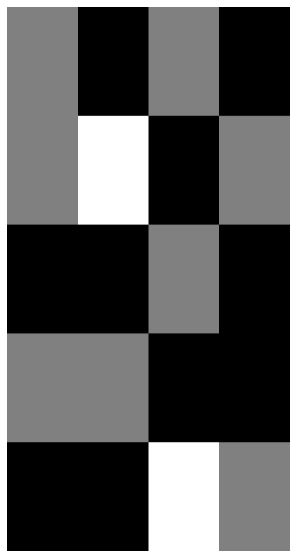

In [42]:
manager.logger.plotFigure(manager.mask_train_val, 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))


In [43]:

train_unique = get_pixel_count_set(manager.label_mask, manager.mask_train_val, 1)
val_unique = get_pixel_count_set(manager.label_mask, manager.mask_train_val, 2)
test_unique = get_pixel_count_set(manager.label_mask, manager.mask_train_val, 0)

total_unique = np.unique(manager.label_mask, return_counts=True)

In [44]:
print("train unique", train_unique)
print("val unique", val_unique)
print("test unique", test_unique)

print("total unique", total_unique)


train unique (array([0, 1, 2], dtype=uint8), array([38253046,   801988, 26191366], dtype=int64))
val unique (array([0, 1, 2], dtype=uint8), array([9179787,  270914, 6860899], dtype=int64))
test unique (array([0, 1, 2], dtype=uint8), array([53470765,   765606, 27321629], dtype=int64))
total unique (array([0, 1, 2], dtype=uint8), array([100903598,   1838508,  60373894], dtype=int64))


In [45]:
print("train unique percentage", np.round(train_unique[1]/np.sum(train_unique[1]), 4))
print("val unique", np.round(val_unique[1]/np.sum(val_unique[1]), 4))
print("test unique", np.round(test_unique[1]/np.sum(test_unique[1]), 4))

train unique percentage [0.5863 0.0123 0.4014]
val unique [0.5628 0.0166 0.4206]
test unique [0.6556 0.0094 0.335 ]


In [46]:

if config["training"] == True:
    # Extracting patches from the idx matrix
    manager.createIdxImage()


In [47]:
if config["training"] == True:
    manager.extractCoords()

In [48]:
if config["training"] == True:
    manager.trainTestSplit()

In [49]:
if config["training"] == True:
    manager.label_mask.shape

In [50]:
if config["training"] == True:

    manager.logger.plotFigure(manager.label_mask[...,-1], 
        name='Reference', cmap=plt.cm.gray, savefig=False)



In [51]:
if config["training"] == True:
    np.unique(manager.label_mask)

In [52]:
if config["training"] == True:
    print(manager.coords_train)

In [53]:
if config["training"] == True:
    manager.retrieveSamplesOfInterest()

In [54]:
if config["training"] == True:
    inputSnipShow = True

In [55]:
# count, unique = np.unique(label_mask, return_counts=True)
# print(count, unique)
# print(unique[1]/unique[0])

In [56]:
'''
count, unique = np.unique(label_mask[mask_test == 1], return_counts=True)
print(count, unique)
print(unique[1]/unique[0])
'''

'\ncount, unique = np.unique(label_mask[mask_test == 1], return_counts=True)\nprint(count, unique)\nprint(unique[1]/unique[0])\n'

In [57]:
'''
count, unique = np.unique(label_mask[mask_train_val == 1], return_counts=True)
print(count, unique)
print(unique[1]/unique[0])
'''

'\ncount, unique = np.unique(label_mask[mask_train_val == 1], return_counts=True)\nprint(count, unique)\nprint(unique[1]/unique[0])\n'

In [58]:
manager.dataset.image_channels

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]

In [59]:
manager.dataset.bands

10

In [60]:
manager.dataset.previewBandsSnip

[[1, 2, 3], [11, 12, 13]]

In [61]:
if config["training"] == True:
    if inputSnipShow == True:
        manager.snipDataset(idx = 1000)


In [62]:
if config["training"] == True:
    if inputSnipShow == True:
        manager.snipDataset(idx = 97)


In [63]:
if config["training"] == True:
    if inputSnipShow == True:

        manager.snipDataset(idx = 500)

In [64]:
if config["training"] == True:
    if inputSnipShow == True:

        manager.snipDataset(idx = 400)

In [65]:
if config["training"] == True:
    if inputSnipShow == True:

        manager.snipDataset(idx = 400)

In [66]:
if config["training"] == True:
    manager.getGenerators()


In [67]:
if config["training"] == True:
    manager.fixChannelNumber()

In [68]:
if config["training"] == True:
    print(manager.path_exp)

In [69]:
if config["training"] == True:
    print(manager.channels)

In [70]:
if config["training"] == True:
    print(manager.image_stack.shape)

In [71]:
if config["training"] == True:
    print("config['training_times']", config["training_times"])

In [72]:
manager.class_n

3

In [73]:
if config["training"] == True:
    for tm in range(config['training_times']):
        manager.repetition_id = tm
        manager.train()

In [74]:
if config["training"] == True:
    manager.plotHistory()


In [75]:
repetition_id = 0

In [76]:
if config["inferring"] != True:
    sys.exit()
else:
    manager.repetition_id = repetition_id

In [77]:
manager.image_stack.shape

(17730, 9200, 21)

In [78]:
manager.patchesHandler.dataset.image_channels[-1]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [79]:
if issubclass(type(dataset), MultipleDates):
	manager.channels = manager.patchesHandler.input_image_shape
	manager.image_stack = manager.image_stack[..., manager.patchesHandler.dataset.image_channels[-1]]
	manager.label_mask = manager.label_mask[...,-1]


In [80]:
manager.image_stack.shape

(17730, 9200, 21)

In [81]:
manager.setPadding()

-30.0 -16.0


In [82]:
import src.network as network
from tensorflow.keras.models import Model, load_model, Sequential
'''
def infer(self):

    self.h, self.w, self.c = self.image1_pad.shape
    self.c = self.channels
    patch_size_rows = self.h//self.n_rows
    patch_size_cols = self.w//self.n_cols
    num_patches_x = int(self.h/patch_size_rows)
    num_patches_y = int(self.w/patch_size_cols)

    ic(self.path_models+ '/' + self.method +'_'+str(self.repetition_id)+'.h5')
    model = load_model(self.path_models+ '/' + self.method +'_'+str(self.repetition_id)+'.h5', compile=False)
    
    if self.classes_mode == False:
        class_n = 3
        self.patchesHandler.class_n = class_n
    else:
        class_n = 2    
        self.patchesHandler.class_n = class_n + 1
    if self.config["loadInference"] == False:
        if self.config["save_probabilities"] == False:
            if self.classes_mode == False:
                self.prob_rec = np.zeros((self.image1_pad.shape[0],self.image1_pad.shape[1], self.config["inference_times"]), dtype = np.float32)
            else:
                self.prob_rec = np.zeros((self.image1_pad.shape[0],self.image1_pad.shape[1], class_n, self.config["inference_times"]), dtype = np.float32)

            # self.prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, self.config["inference_times"]), dtype = np.float32)
        print("Dropout training mode: {}".format(self.config['dropout_training']))
        new_model = network.build_resunet_dropout_spatial(input_shape=(patch_size_rows,patch_size_cols, self.c), 
            nb_filters = self.nb_filters, n_classes = class_n, dropout_seed = None, training=self.config['dropout_training'])

        for l in range(1, len(model.layers)):
            new_model.layers[l].set_weights(model.layers[l].get_weights())
        
        

        metrics_all =[]
        with tf.device('/cpu:0'):
            for tm in range(0,self.config["inference_times"]):

                print('time: ', tm)

                
                # Recinstructing predicted map
                start_test = time.time()
                
                prob_reconstructed = self.patchesHandler.infer(
                        new_model, self.image1_pad, self.h, self.w, 
                        num_patches_x, num_patches_y, patch_size_rows, 
                        patch_size_cols, classes_mode = self.classes_mode)
                        
                ts_time =  time.time() - start_test

                if self.config["save_probabilities"] == True:
                    np.save(self.path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
                else:
                    self.prob_rec[...,tm] = prob_reconstructed
                
                metrics_all.append(ts_time)
                del prob_reconstructed
            metrics_ = np.asarray(metrics_all)
            # Saving test time
            np.save(self.path_exp+'/metrics_ts.npy', metrics_)
    del self.image1_pad
'''

'\ndef infer(self):\n\n    self.h, self.w, self.c = self.image1_pad.shape\n    self.c = self.channels\n    patch_size_rows = self.h//self.n_rows\n    patch_size_cols = self.w//self.n_cols\n    num_patches_x = int(self.h/patch_size_rows)\n    num_patches_y = int(self.w/patch_size_cols)\n\n    ic(self.path_models+ \'/\' + self.method +\'_\'+str(self.repetition_id)+\'.h5\')\n    model = load_model(self.path_models+ \'/\' + self.method +\'_\'+str(self.repetition_id)+\'.h5\', compile=False)\n    \n    if self.classes_mode == False:\n        class_n = 3\n        self.patchesHandler.class_n = class_n\n    else:\n        class_n = 2    \n        self.patchesHandler.class_n = class_n + 1\n    if self.config["loadInference"] == False:\n        if self.config["save_probabilities"] == False:\n            if self.classes_mode == False:\n                self.prob_rec = np.zeros((self.image1_pad.shape[0],self.image1_pad.shape[1], self.config["inference_times"]), dtype = np.float32)\n            else:

In [83]:
'''
import types

manager.infer = types.MethodType(infer, manager)
'''


'\nimport types\n\nmanager.infer = types.MethodType(infer, manager)\n'

In [84]:
manager.infer()

time:  0
Loading model in: D:/Jorge/datasets/deforestation/experiments/PA/exp1/models/resunet_0.h5
runtime_repetition 61.08
time:  1
Loading model in: D:/Jorge/datasets/deforestation/experiments/PA/exp1/models/resunet_1.h5
runtime_repetition 65.19
time:  2
Loading model in: D:/Jorge/datasets/deforestation/experiments/PA/exp1/models/resunet_2.h5
runtime_repetition 64.44
time:  3
Loading model in: D:/Jorge/datasets/deforestation/experiments/PA/exp1/models/resunet_3.h5
runtime_repetition 64.67
time:  4
Loading model in: D:/Jorge/datasets/deforestation/experiments/PA/exp1/models/resunet_4.h5
runtime_repetition 64.3
time:  5
Loading model in: D:/Jorge/datasets/deforestation/experiments/PA/exp1/models/resunet_5.h5
runtime_repetition 65.33
time:  6
Loading model in: D:/Jorge/datasets/deforestation/experiments/PA/exp1/models/resunet_6.h5
runtime_repetition 69.41
time:  7
Loading model in: D:/Jorge/datasets/deforestation/experiments/PA/exp1/models/resunet_7.h5
runtime_repetition 67.85
time:  8


In [85]:
manager.loadPredictedProbabilities()

In [86]:
manager.prob_rec.shape

(17760, 9216, 10)

In [87]:
'''
if useLessInferenceRuns == True:
    ic(reducedInferenceRuns)

    prob_rec_all = prob_rec.copy()
    prob_rec = prob_rec_all[:reducedInferenceRuns]
    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))
'''

'\nif useLessInferenceRuns == True:\n    ic(reducedInferenceRuns)\n\n    prob_rec_all = prob_rec.copy()\n    prob_rec = prob_rec_all[:reducedInferenceRuns]\n    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))\n'

In [88]:
manager.prob_rec.shape

(17760, 9216, 10)

In [89]:
manager.getMeanProb()

In [90]:
manager.logger.getStats(manager.mean_prob)

ic| Logger.py:121 in getStats()
    np.min(value): 1.4644367e-15
    np.mean(value): 0.012334157
    np.max(value): 0.9999992


In [91]:
ic(manager.mean_prob.shape)

ic| 3703776524.py:1 in <cell line: 1>()
    manager.mean_prob.shape: (17760, 9216)


(17760, 9216)

In [92]:
manager.unpadMeanProb()

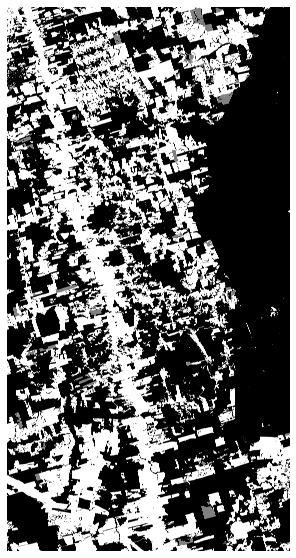

In [93]:
manager.logger.plotFigure(manager.label_mask, 
            name='Reference mask', figsize=(10,10), cmap=plt.cm.gray, savefig=True)

In [94]:
manager.squeezeLabel()

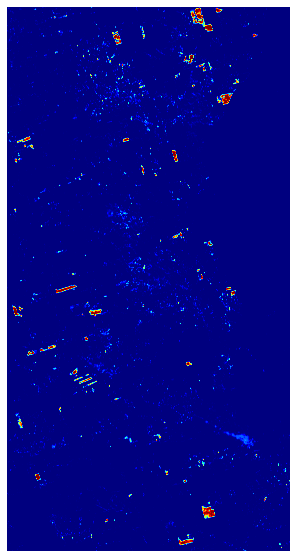

In [95]:
manager.setMeanProbNotConsideredAreas()
manager.logger.plotFigure(manager.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

In [96]:
print(manager.label_mask.shape)

(17730, 9200)


In [97]:
# manager.getLabelTest()

In [98]:
# manager.getMAP()

In [99]:
manager.prob_rec.shape

(17760, 9216, 10)

In [100]:
manager.preprocessProbRec()
print(manager.prob_rec.shape)

(10, 17760, 9216, 1)


In [101]:
manager.prob_rec.shape

(10, 17760, 9216, 1)

In [102]:
manager.logger.getStats(manager.prob_rec)

ic| Logger.py:121 in getStats()
    np.min(value): 0.0
    np.mean(value): 0.012330051
    np.max(value): 1.0


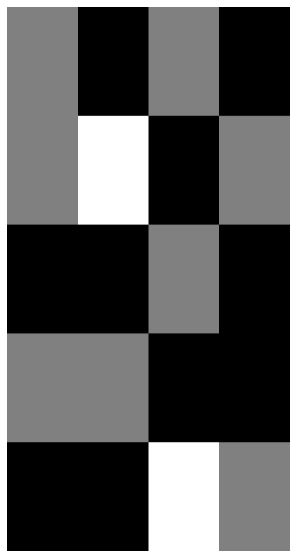

In [103]:
manager.logger.plotFigure(manager.mask_train_val, 
            name=manager.dataset.site + manager.title_name + ' Train val mask.png', figsize=(10,10), savefig=False)

In [104]:
manager.getLabelCurrentDeforestation()

In [105]:
manager.applyProbabilityThreshold()

(17730, 9200)
(array([0., 1.], dtype=float32), array([161675361,   1440639], dtype=int64))


ic| base.py:464 in applyProbabilityThreshold()
    self.predicted_unpad.shape: (17730, 9200)
    self.predicted.shape: (17730, 9200)


In [106]:
manager.getTestValues()

ic| base.py:487 in getTestValues()- predicted_test.shape: (81558000,)
ic| base.py:496 in getTestValues()- predicted_test.shape: (54236371,)


In [107]:
manager.removeSmallPolygons()

ic| metrics.py:213 in removeSmallPolygonsForMetrics()
    np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161675361,   1440639], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161789622,   1326378], dtype=int64))
ic| metrics.py:215 in removeSmallPolygonsForMetrics()
    np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([163001739,    114261], dtype=int64))


In [108]:
manager.calculateMetrics()

ic| base.py:540 in calculateMetrics()
    self.f1: 81.41
    self.precision: 97.07
    self.recall: 70.1


In [109]:
manager.getValidationValuesForMetrics()
manager.calculateMetricsValidation()

ic| base.py:469 in getValidationValuesForMetrics()
    self.label_mask_val.shape: (16311600,)
ic| base.py:475 in getValidationValuesForMetrics()
    self.label_mask_val_valid.shape: (9439113,)
ic| base.py:551 in calculateMetricsValidation()
    f1_val: 82.77
    precision_val: 89.56
    recall_val: 76.94
    mAP_val: 85.73


In [110]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    manager.calculateMAPWithoutSmallPolygons()

In [111]:
manager.get_label_no_buffer()

D:/Jorge/datasets/deforestation/PA/deforestation_past_years.tif
Loaded deforestation past years


ic| dataset.py:706 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| dataset.py:709 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| dataset.py:713 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/PA/deforestation_before_2008_PA.tif


ic| dataset.py:717 in loadLabelFromDate()
    np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| dataset.py:719 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| dataset.py:698 in loadLabel()
    label_per_date.shape: (17730, 9203, 1)


In [112]:
manager.getErrorMask()

(array([0., 1.], dtype=float32), array([162427946,    688054], dtype=int64))


In [113]:
manager.getErrorMaskToShowRGB()

[0. 1.]


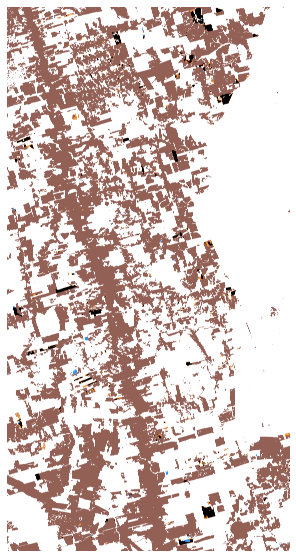

In [114]:
manager.logger.plotFigure(manager.error_mask_to_show_rgb[...,::-1], 
            name=manager.dataset.site + manager.title_name + ' error mask color.png', 
            figsize=(10,10), savefig=True, dpi=300)

In [115]:
'''
import types

manager.setUncertainty = types.MethodType(setUncertainty, manager)
'''


'\nimport types\n\nmanager.setUncertainty = types.MethodType(setUncertainty, manager)\n'

In [116]:
manager.config['uncertainty_method']

'pred_entropy'

In [117]:
manager.config['site']

'PA'

In [118]:
# manager.config['uncertainty_method'] = "pred_var"


In [119]:
print(np.min(manager.prob_rec), np.mean(manager.prob_rec), np.max(manager.prob_rec))
print(np.std(manager.prob_rec))
print(manager.prob_rec.shape)

0.0 0.012330051 1.0
0.08882106
(10, 17760, 9216, 1)


In [120]:
manager.setUncertainty()

pred_mean 1.4644367e-15 0.012334157 0.9999992
K = 1, pred_mean shape (17760, 9216, 1)


In [121]:
# manager.uncertainty_map[manager.uncertainty_map>1] = 1

In [122]:
manager.logger.getStats(manager.uncertainty_map)

ic| Logger.py:121 in getStats()
    np.min(value): 4.9258988e-14
    np.mean(value): 0.010970183
    np.max(value): 0.36787948


In [123]:
manager.getUncertaintyToShow()
manager.logger.getStats(manager.uncertainty_to_show)


ic| Logger.py:121 in getStats()
    np.min(value): 0.0
    np.mean(value): 0.009594776
    np.max(value): 0.36787948


ic| 3944692317.py:4 in <cell line: 4>()
    manager.uncertainty_to_show.shape: (17730, 9200)


(17730, 9200)

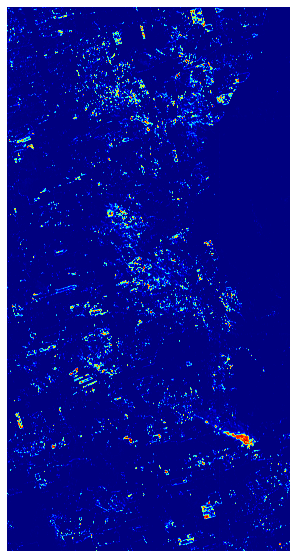

In [124]:

manager.logger.plotFigure(manager.uncertainty_to_show, 
            name=manager.dataset.site + manager.title_name + ' uncertainty '+manager.config['uncertainty_method']+'.png', figsize=(10,10), cmap='jet', savefig=True)

ic(manager.uncertainty_to_show.shape)



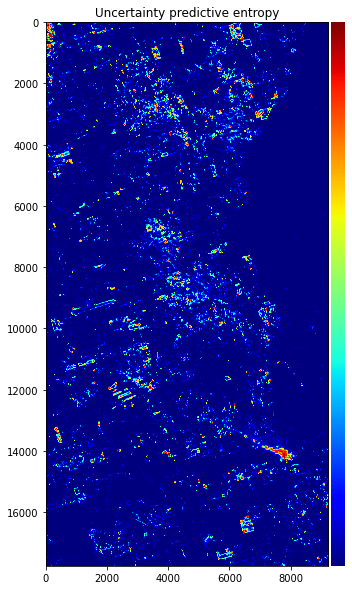

In [125]:

import src.uncertainty
fig, ax = plt.subplots(1,1,figsize=(10,10))
src.uncertainty.show_im(manager.uncertainty_map, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('output/figures/Para' + manager.title_name + ' uncertainty '+manager.config['uncertainty_method']+'.png', 
    dpi=150, bbox_inches='tight')

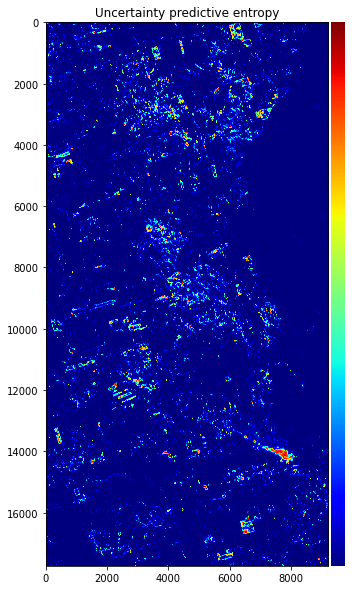

In [126]:

import src.uncertainty
fig, ax = plt.subplots(1,1,figsize=(10,10))
src.uncertainty.show_im(manager.uncertainty_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('output/figures/Para' + manager.title_name + ' uncertainty '+manager.config['uncertainty_method']+'.png', 
    dpi=150, bbox_inches='tight')

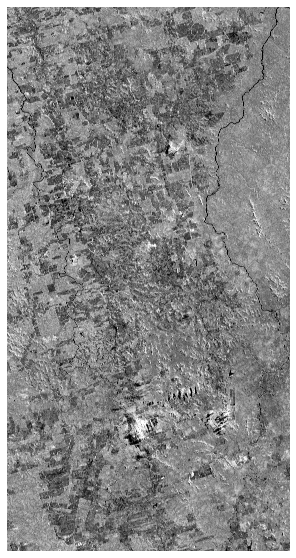

In [127]:

manager.logger.plotFigure(manager.image_stack[...,7], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

In [128]:
np.unique(manager.mask_train_val, return_counts=True)

(array([0, 1, 2], dtype=uint8),
 array([81558000, 65246400, 16311600], dtype=int64))

In [129]:
manager.error_mask.shape

(17730, 9200)

In [130]:
manager.npad

((0, 30), (0, 16), (0, 0))

In [131]:
manager.getValidationValues2()
manager.getTestValues2()

ic| base.py:591 in getTestValues2()
    self.label_mask.shape: (17730, 9200)
ic| base.py:592 in getTestValues2()
    self.mask_test.shape: (17730, 9200)
ic| base.py:596 in getTestValues2()
    self.label_mask_test.shape: (81558000,)
ic| base.py:604 in getTestValues2()
    self.error_mask_test.shape: (54181542,)


In [133]:
# manager.logger.plotCropSample(manager)

In [134]:
if config["plotLandsat"] == True:
    label_tmp_dates = []
    for date in dataset.prodes_dates:
        label_tmp_date = dataset.loadLabelFromDate(date)
        label_tmp_date = label_tmp_date[:manager.mask_tiles.shape[0], :manager.mask_tiles.shape[1]]
        label_tmp_dates.append(label_tmp_date)

In [135]:
if config["plotLandsat"] == True:
    # del manager.image_stack
    import src.lansdatLoader as ll
    import importlib
    importlib.reload(ll)
    landsatLoader = ll.LandsatLoader(dataset)
    ims = landsatLoader.load()
    for idx in range(len(ims)):
        ims[idx] = ims[idx][:manager.mask_tiles.shape[0], :manager.mask_tiles.shape[1],:]
    ims = landsatLoader.darken_past_deforestation(ims, manager.label_no_buffer)
    ims = landsatLoader.add_deforestation_edges_by_date(ims, label_tmp_dates[:])

In [136]:
if config["plotLandsat"] == True:
    logger.plotCropSampleLandsat(manager, ims)

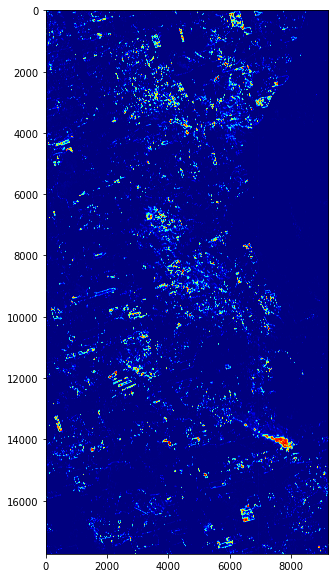

In [137]:
plt.figure(figsize=(10, 10))
plt.imshow(manager.uncertainty_to_show, cmap = 'jet')


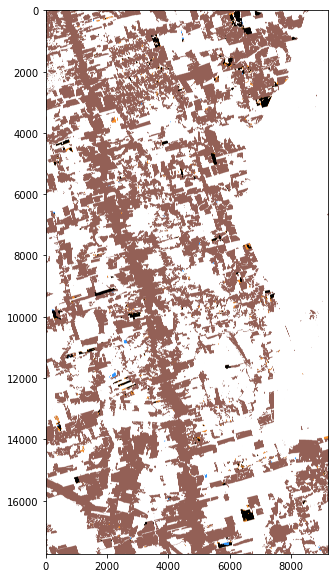

In [138]:
plt.figure(figsize=(10, 10))
plt.imshow(manager.error_mask_to_show_rgb[...,::-1])


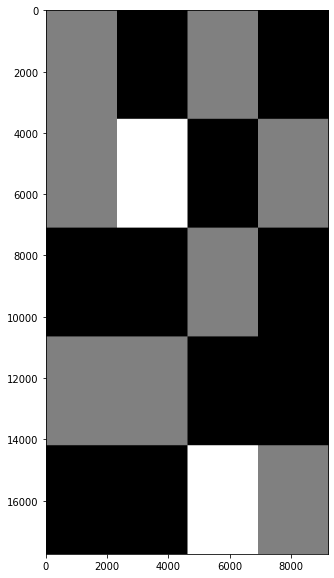

In [139]:
plt.figure(figsize=(10, 10))
plt.imshow(manager.mask_train_val, cmap='gray')

In [144]:
if config['site'] == 'PI':
    manager.dataset.previewLims1 = np.array([2000, 3000, 1500, 2500])
    # manager.dataset.previewLims2 = np.array([6300, 7300, 10000, 11000])
    manager.dataset.previewLims2 = np.array([2200, 3200, 9000, 10000])
elif config['site'] == 'MS':
    manager.dataset.previewLims1 = np.array([13250, 14250, 4000, 5000])
    # manager.dataset.previewLims2 = np.array([6300, 7300, 10000, 11000])
    manager.dataset.previewLims2 = np.array([13500, 14500, 16250, 17250])
    

ic| Logger.py:279 in plotCropSampleT0T1()
    np.unique(manager.mask_test[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)


ic| Logger.py:281 in plotCropSampleT0T1()
    np.unique(manager.mask_test[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
ic| Logger.py:279 in plotCropSampleT0T1()
    np.unique(manager.mask_test[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| Logger.py:281 in plotCropSampleT0T1()
    np.unique(manager.mask_test[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
ic| Logger.py:279 in plotCropSampleT0T1()
    np.uni

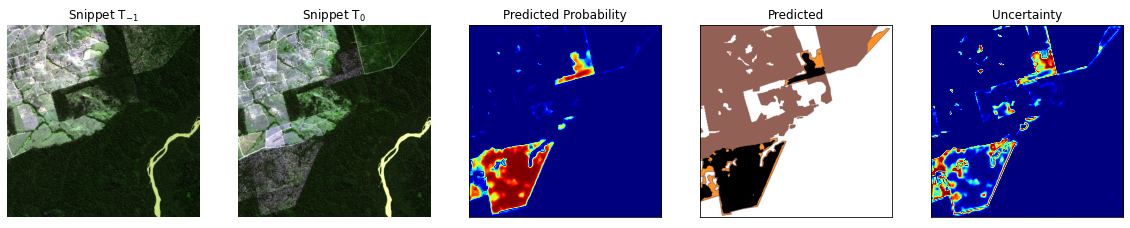

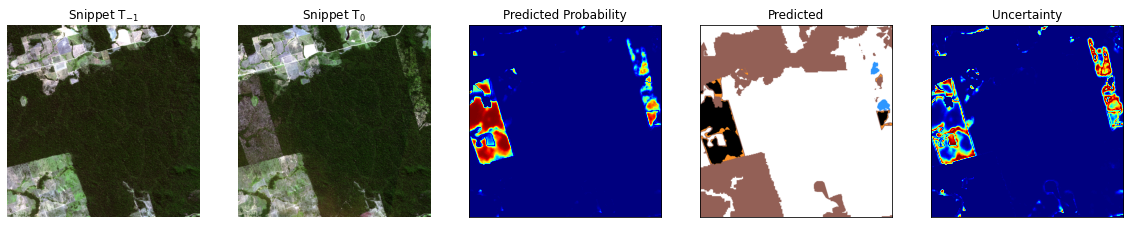

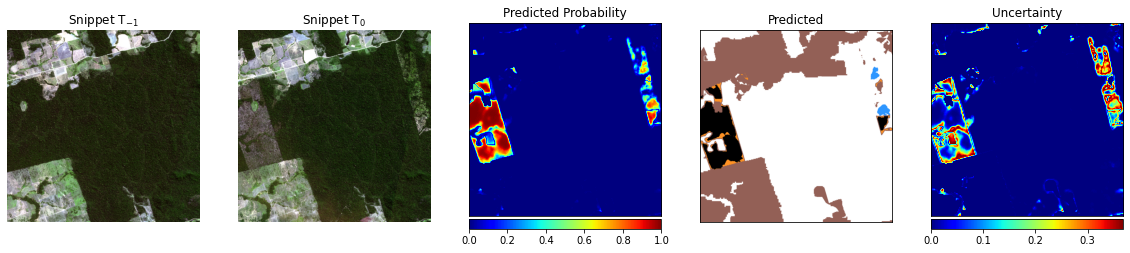

In [145]:
'''
manager.dataset.previewLims1 = np.array([2500, 5000, 15000, 17500])
manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='0')
manager.dataset.previewLims1 = np.array([12500, 15000, 2500, 5000])
manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='1')
manager.dataset.previewLims1 = np.array([15000, 17500, 2000, 3000])
manager.dataset.previewLims1 = np.array([5000, 7500, 15000, 17500])

manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='2')
'''

manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='1')
manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims2, save_name='2')

manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims2, colorbar=True, save_name='Colorbar')

In [146]:
manager.logger.getStats(manager.uncertainty)


ic| Logger.py:121 in getStats()
    np.min(value): 2.024166e-08
    np.mean(value): 0.012984787
    np.max(value): 0.36787948


In [147]:
'''
manager.getOtherUncertaintyMetrics()
print(manager.sUEO)

print(manager.ece_score)  
'''

'\nmanager.getOtherUncertaintyMetrics()\nprint(manager.sUEO)\n\nprint(manager.ece_score)  \n'

In [148]:
if config["plotPOI"] == True and config['site'] == 'PA':

    print(manager.mean_prob.shape)
    font = {'family': "Times New Roman",
            'color':  'white',
            'weight': 'bold',
            'size': 24,
            }

    lims = dataset.previewLims1
    im = manager.uncertainty_map[lims[0]:lims[1], lims[2]:lims[3]]
    plt.figure(figsize=(10,10))
    plt.imshow(im, cmap='jet')

    letters = ['A', 'B', 'C', 'D', 'E', 'F']

    for poi_id in range(4):
            
            plt.text(manager.dataset.snippet_coords['snippet_id0'][poi_id][1], 
                    manager.dataset.snippet_coords['snippet_id0'][poi_id][0], 
                    letters[poi_id], fontdict=font)
    plt.axis('off')

    plt.savefig(os.path.join('output/pdf_plot_results', 
                            'pdf_plot_poi0.png'), 
    dpi=150, bbox_inches='tight')

    lims = dataset.previewLims2
    im = manager.uncertainty_map[lims[0]:lims[1], lims[2]:lims[3]]
    plt.figure(figsize=(10,10))
    plt.imshow(im, cmap='jet')

    letters = ['E', 'F']

    print(manager.dataset.snippet_coords['snippet_id1'])
    for poi_id in range(2):
            
            plt.text(manager.dataset.snippet_coords['snippet_id1'][poi_id][1], 
                    manager.dataset.snippet_coords['snippet_id1'][poi_id][0], 
                    letters[poi_id], fontdict=font)
    plt.axis('off')
            
    plt.savefig(os.path.join('output/pdf_plot_results', 
                            'pdf_plot_poi1.png'), 
    dpi=150, bbox_inches='tight')

In [149]:
if config["plotPOI"] == True and config['site'] == 'PA':
    manager.getPOIValues()


In [150]:

if config["plotPOI"] == True and config['site'] == 'PA':
    import pickle
    with open('output/log/log_ensemble_.pkl', 'wb') as f:
                pickle.dump(manager.snippet_poi_results, f)


In [151]:
from scipy import optimize  

manager.getOptimalUncertaintyThreshold(bounds=(np.min(manager.uncertainty) + 0.000015, np.max(manager.uncertainty) - 0.0015))

ic| base.py:842 in getOptimalUncertaintyThreshold()
    bounds: (1.5020241660791953e-05, 0.3663794801235199)


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


0.13995379164653365
threshold 0.13995379164653365


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1740059,)
    predicted_test_classified_incorrect.shape: (1740059,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1740059
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1740059
    len(label_mask_current_deforestation_test): 54181542


[0.99640694 0.90178259 0.45218035 0.03211535 0.92723431 0.49899557
 0.11222988]
0.22644070871864697
threshold 0.22644070871864697


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1084553,)
    predicted_test_classified_incorrect.shape: (1084553,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1084553
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1084553
    len(label_mask_current_deforestation_test): 54181542


[0.98998729 0.87605164 0.54998745 0.02001702 0.90639536 0.4056379
 0.15304674]
0.08650193731377409
threshold 0.08650193731377409


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (2428157,)
    predicted_test_classified_incorrect.shape: (2428157,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2428157
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2428157
    len(label_mask_current_deforestation_test): 54181542


[0.99743602 0.91535116 0.3806972  0.04481521 0.9407373  0.54831233
 0.08570553]
0.16382488992218772
threshold 0.16382488992218772


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1526551,)
    predicted_test_classified_incorrect.shape: (1526551,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1526551
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1526551
    len(label_mask_current_deforestation_test): 54181542


[0.99534056 0.89469633 0.48009168 0.02817474 0.92114952 0.47663336
 0.12335948]
0.15557881525584846
threshold 0.15557881525584846


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1596866,)
    predicted_test_classified_incorrect.shape: (1596866,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1596866
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1596866
    len(label_mask_current_deforestation_test): 54181542


[0.9957807  0.89706136 0.47051749 0.02947251 0.92323749 0.48465218
 0.11947071]
0.152449353011841
threshold 0.152449353011841


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1624248,)
    predicted_test_classified_incorrect.shape: (1624248,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1624248
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1624248
    len(label_mask_current_deforestation_test): 54181542


[0.99593682 0.89796522 0.46683656 0.02997788 0.92402804 0.48764806
 0.1180216 ]
0.14767647327880365
threshold 0.14767647327880365


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1667330,)
    predicted_test_classified_incorrect.shape: (1667330,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1667330
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1667330
    len(label_mask_current_deforestation_test): 54181542


[0.99616639 0.89945538 0.46123486 0.03077303 0.92520838 0.49205004
 0.11582736]
0.1520127155037724
threshold 0.1520127155037724


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1628137,)
    predicted_test_classified_incorrect.shape: (1628137,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1628137
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1628137
    len(label_mask_current_deforestation_test): 54181542


[0.99595788 0.89813948 0.46628584 0.03004966 0.9241486  0.48806924
 0.11783364]
0.15273191749954454
threshold 0.15273191749954454


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1621745,)
    predicted_test_classified_incorrect.shape: (1621745,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1621745
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1621745
    len(label_mask_current_deforestation_test): 54181542


[0.99592548 0.89787691 0.46718211 0.02993169 0.92394894 0.48737091
 0.11815086]
0.1523311590701359
threshold 0.1523311590701359


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1625309,)
    predicted_test_classified_incorrect.shape: (1625309,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1625309
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1625309
    len(label_mask_current_deforestation_test): 54181542


[0.99594132 0.8980071  0.46669348 0.02999747 0.92406108 0.48775957
 0.11796791]
0.1522749426149688
threshold 0.1522749426149688


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1625846,)
    predicted_test_classified_incorrect.shape: (1625846,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1625846
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1625846
    len(label_mask_current_deforestation_test): 54181542


[0.9959464  0.89802726 0.46661789 0.03000738 0.92407388 0.48781961
 0.1179413 ]
0.15236449466290544
threshold 0.15236449466290544


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1625018,)
    predicted_test_classified_incorrect.shape: (1625018,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1625018
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1625018
    len(label_mask_current_deforestation_test): 54181542
ic| base.py:846 in getOptimalUncertaintyThreshold()
    self.threshold_optimal: 0.1523311590701359


[0.9959417  0.89798319 0.46673803 0.0299921  0.92404773 0.48773125
 0.11797912]


In [152]:
manager.getUncertaintyMetricsFromOptimalThreshold()

threshold:  0.1523311590701359
threshold 0.1523311590701359


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1625309,)
    predicted_test_classified_incorrect.shape: (1625309,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1625309
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1625309
    len(label_mask_current_deforestation_test): 54181542


[0.99594132 0.8980071  0.46669348 0.02999747 0.92406108 0.48775957
 0.11796791]
threshold 0.1523311590701359
(54181542,) (54181542,)


ic| base.py:877 in getUncertaintyMetricsFromOptimalThreshold()
    self.m_optimal: {'AA': array([0.02999747]),
                     'UEO': array([0.11796791]),
                     'f1': 81.41,
                     'f1_H': array([0.63849418]),
                     'f1_L': array([0.94444217]),
                     'precision_H': array([0.92406108]),
                     'precision_L': array([0.99594132]),
                     'recall_H': array([0.48775957]),
                     'recall_L': array([0.8980071]),
                     'recall_Ltotal': array([0.46669348])}
ic| base.py:878 in getUncertaintyMetricsFromOptimalThreshold()
    self.m_audited_optimal: {'f1': array([0.97182636]),
                             'precision': array([0.99799569]),
                             'recall': array([0.94699438])}


cm_audited [[53439287     1409]
 [   39269   701577]]
[0.99799569 0.94699438]


{'metrics': {'precision_L': array([0.99594132]),
  'recall_L': array([0.8980071]),
  'recall_Ltotal': array([0.46669348]),
  'AA': array([0.02999747]),
  'precision_H': array([0.92406108]),
  'recall_H': array([0.48775957]),
  'UEO': array([0.11796791]),
  'f1_L': array([0.94444217]),
  'f1_H': array([0.63849418]),
  'f1': 81.41},
 'metrics_audited': {'precision': array([0.99799569]),
  'recall': array([0.94699438]),
  'f1': array([0.97182636])},
 'exp': 1}

In [153]:
from src import metrics as _metrics

def getUncertaintyAAValues(self):



    # self.threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

    # self.threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003]
    if self.config['uncertainty_method'] == "pred_entropy_single":
        self.threshold_list = [0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                            0.25, 0.27, 0.3, 0.34, 0.36, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
    if self.config['uncertainty_method'] == "pred_entropy":
            if self.classes_mode == False:
                # self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                #            0.25, 0.27, 0.3, 0.34, 0.36, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
                self.threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                        0.25, 0.27, 0.3, 0.34, 0.36, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]                            
                    # self.threshold_list = [0.0025, 0.025, 0.05, 0.1, 0.2, 0.4, 
                    #         0.5, 0.6, 0.7, 0.8, 0.9, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
            else:
                    self.threshold_list = [0.0025, 0.025, 0.05, 0.075, 0.1, 0.2, 0.4, 
                    0.5, 0.6, 0.7, 0.8, 0.9, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
                    
                    # self.threshold_list = [0.13, 0.15, 0.2, 0.225, 
                    # 0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]
    elif self.config['uncertainty_method'] == "pred_var":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*0.13/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.0015, np.max(self.uncertainty)-0.0008]
            self.threshold_list = np.linspace(np.min(self.uncertainty) + 0.000015, np.max(self.uncertainty) - 0.0015, 19)
            self.threshold_list = [8e-05, 1.5e-04, 1.5e-03] + \
                list(np.linspace(np.min(self.uncertainty) + 0.000015, np.max(self.uncertainty) - 0.0015, 19))
            self.threshold_list.insert(0, self.threshold_list.pop(3))

            # self.threshold_list = np.linspace(np.min(self.uncertainty) + 0.00000015, np.max(self.uncertainty) - 0.0015, 19)
            # self.threshold_list = np.logspace(np.min(self.uncertainty) + 0.00000015, np.max(self.uncertainty) - 0.0015, 19)

    elif self.config['uncertainty_method'] == "MI":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*0.235/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
            self.threshold_list = [0.00001, 0.0005, 0.0001] + [x*0.235/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
    elif self.config['uncertainty_method'] == "KL":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*1.0/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.006, np.max(self.uncertainty)-0.003]
    elif self.config['uncertainty_method'] == "evidential":
            # self.threshold_list = [0.015, 0.03, 0.04]
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [ 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [ 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]

            self.threshold_list = [0.13, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]

            # self.threshold_list = [ 0.15, 0.2,  
            #          0.3, 0.35, 0.4, 0.5, 0.6, 0.7]

            # self.threshold_list = [0.015,0.1, 0.2, 0.27, 0.36, 0.45, 0.55, 0.65]

            # self.threshold_list = [x*1.0/0.36 for x in self.threshold_list] + [np.max(uncertainty)-0.006, np.max(uncertainty)-0.003]
                    
            # self.threshold_list = np.linspace(np.min(uncertainty) + 0.0015, np.max(uncertainty) - 0.0015, 19)
    print(self.threshold_list)
    self.loadThresholdMetrics = False
    if self.loadThresholdMetrics == False:
            # self.threshold_list = [0.1]
            # y_test
            ic(self.uncertainty.shape, self.label_mask_current_deforestation_test.shape)

            metrics_values = _metrics.getAA_Recall(self.uncertainty, 
                    self.label_mask_current_deforestation_test, 
                    self.predicted_test, self.threshold_list)

            # ic(metrics_values)


    self.m = {'precision_L': metrics_values[:,0],
            'recall_L': metrics_values[:,1],
            'recall_Ltotal': metrics_values[:,2],
            'AA': metrics_values[:,3],
            'precision_H': metrics_values[:,4],
            'recall_H': metrics_values[:,5],
            'UEO': metrics_values[:,6]}

    self.m['f1_L'] = 2*self.m['precision_L']*self.m['recall_L']/(self.m['precision_L']+self.m['recall_L'])
    self.m['f1_H'] = 2*self.m['precision_H']*self.m['recall_H']/(self.m['precision_H']+self.m['recall_H'])


In [154]:
manager.config['uncertainty_method']

'pred_entropy'

In [155]:
# manager.threshold_list

In [156]:


# manager.threshold_list.insert(0, manager.threshold_list.pop(3))

In [157]:

import types

manager.getUncertaintyAAValues = types.MethodType(getUncertaintyAAValues, manager)



Get precision-recall threshold

In [158]:

manager.getUncertaintyAAValues()

ic| 642846373.py:73 in getUncertaintyAAValues()
    self.uncertainty.shape: (54181542,)
    self.label_mask_current_deforestation_test.shape: (54181542,)


[0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 0.25, 0.27, 0.3, 0.34, 0.36, 0.3648794801235199, 0.3663794801235199]
threshold 0.005


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (8269968,)
    predicted_test_classified_incorrect.shape: (8269968,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 8269968
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 8269968
    len(label_mask_current_deforestation_test): 54181542


[1.         0.94966548 0.10691021 0.15263442 0.96561461 0.66941519
 0.02816151]
threshold 0.0075


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (7222469,)
    predicted_test_classified_incorrect.shape: (7222469,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 7222469
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 7222469
    len(label_mask_current_deforestation_test): 54181542


[1.         0.94782424 0.13886017 0.13330128 0.96373104 0.65859097
 0.03203428]
threshold 0.01


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (6519588,)
    predicted_test_classified_incorrect.shape: (6519588,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 6519588
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 6519588
    len(label_mask_current_deforestation_test): 54181542


[1.         0.94512363 0.16247641 0.12032858 0.96220053 0.65027784
 0.03527454]
threshold 0.015


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (5594097,)
    predicted_test_classified_incorrect.shape: (5594097,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 5594097
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 5594097
    len(label_mask_current_deforestation_test): 54181542


[1.         0.94059979 0.19516742 0.10324728 0.95985553 0.63822416
 0.04070511]
threshold 0.025


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (4544816,)
    predicted_test_classified_incorrect.shape: (4544816,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 4544816
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 4544816
    len(label_mask_current_deforestation_test): 54181542


[0.99941311 0.93395913 0.23905373 0.08388126 0.95648638 0.6208127
 0.04927851]
threshold 0.05


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (3301309,)
    predicted_test_classified_incorrect.shape: (3301309,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 3301309
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 3301309
    len(label_mask_current_deforestation_test): 54181542


[0.9982271  0.92523931 0.31312311 0.06093051 0.94956889 0.58623905
 0.06567002]
threshold 0.08


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (2547282,)
    predicted_test_classified_incorrect.shape: (2547282,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2547282
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2547282
    len(label_mask_current_deforestation_test): 54181542


[0.99752248 0.91702062 0.37010526 0.04701383 0.94236603 0.55475688
 0.08229211]
threshold 0.1


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (2213724,)
    predicted_test_classified_incorrect.shape: (2213724,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2213724
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2213724
    len(label_mask_current_deforestation_test): 54181542


[0.9972036  0.91250069 0.40096052 0.04085753 0.93741354 0.5351567
 0.09268399]
threshold 0.15


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1646360,)
    predicted_test_classified_incorrect.shape: (1646360,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1646360
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1646360
    len(label_mask_current_deforestation_test): 54181542


[0.99605879 0.8988167  0.46394527 0.03038599 0.9246368  0.48988536
 0.11690968]
threshold 0.2


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1257678,)
    predicted_test_classified_incorrect.shape: (1257678,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1257678
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1257678
    len(label_mask_current_deforestation_test): 54181542


[0.99272771 0.88382563 0.52016613 0.0232123  0.91246858 0.43940701
 0.14013141]
threshold 0.225


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1093832,)
    predicted_test_classified_incorrect.shape: (1093832,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1093832
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1093832
    len(label_mask_current_deforestation_test): 54181542


[0.99008535 0.87648847 0.54833798 0.02018828 0.9069275  0.40766566
 0.15227352]
threshold 0.25


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (936736,)
    predicted_test_classified_incorrect.shape: (936736,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 936736
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 936736
    len(label_mask_current_deforestation_test): 54181542


[0.98767714 0.86896969 0.57836851 0.01728884 0.897915   0.36659348
 0.16614317]
threshold 0.27


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (819973,)
    predicted_test_classified_incorrect.shape: (819973,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 819973
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 819973
    len(label_mask_current_deforestation_test): 54181542


[0.98588712 0.86221698 0.60244369 0.01513381 0.88716696 0.32700286
 0.17767945]
threshold 0.3


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (654074,)
    predicted_test_classified_incorrect.shape: (654074,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 654074
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 654074
    len(label_mask_current_deforestation_test): 54181542


[0.98132756 0.85048001 0.63951482 0.0120719  0.87242727 0.24772814
 0.19413893]
threshold 0.34


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (367349,)
    predicted_test_classified_incorrect.shape: (367349,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 367349
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 367349
    len(label_mask_current_deforestation_test): 54181542


[0.97225327 0.82501699 0.69153913 0.00677997 0.86918098 0.05825964
 0.23220662]
threshold 0.36


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (188324,)
    predicted_test_classified_incorrect.shape: (188324,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:297: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 188324
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 188324
    len(label_mask_current_deforestation_test): 54181542


[0.97070539 0.76755388 0.70096484 0.0034758         nan 0.
 0.17790917]
threshold 0.3648794801235199


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (114932,)
    predicted_test_classified_incorrect.shape: (114932,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:297: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 114932
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 114932
    len(label_mask_current_deforestation_test): 54181542


[0.97070539 0.74017848 0.70096484 0.00212124        nan 0.
 0.12543865]
threshold 0.3663794801235199


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (81123,)
    predicted_test_classified_incorrect.shape: (81123,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:297: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 81123
    len(label_mask_current_deforestation_test): 54181542
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 81123
    len(label_mask_current_deforestation_test): 54181542


[0.97070539 0.72814984 0.70096484 0.00149724        nan 0.
 0.09515438]


In [159]:
manager.getUncertaintyAAAuditedValues()

ic| base.py:733 in getUncertaintyAAAuditedValues()
    self.uncertainty.shape: (54181542,)
    self.label_mask_current_deforestation_test.shape: (54181542,)


threshold 0.005
(54181542,) (54181542,)
cm_audited [[53440696        0]
 [    4198   736648]]
[1.         0.99433351]
threshold 0.0075
(54181542,) (54181542,)
cm_audited [[53440696        0]
 [    5663   735183]]
[1.         0.99235604]
threshold 0.01
(54181542,) (54181542,)
cm_audited [[53440696        0]
 [    6989   733857]]
[1.         0.99056619]
threshold 0.015
(54181542,) (54181542,)
cm_audited [[53440696        0]
 [    9131   731715]]
[1.        0.9876749]
threshold 0.025
(54181542,) (54181542,)
cm_audited [[53440592      104]
 [   12523   728323]]
[0.99985723 0.98309635]
threshold 0.05
(54181542,) (54181542,)
cm_audited [[53440284      412]
 [   18744   722102]]
[0.99942977 0.9746992 ]
threshold 0.08
(54181542,) (54181542,)
cm_audited [[53440015      681]
 [   24811   716035]]
[0.99904983 0.96650991]
threshold 0.1
(54181542,) (54181542,)
cm_audited [[53439863      833]
 [   28484   712362]]
[0.99883202 0.96155206]
threshold 0.15
(54181542,) (54181542,)
cm_audited [[53439336  

ic| base.py:739 in getUncertaintyAAAuditedValues()
    metric_values_audited: array([[1.        , 0.99433351],
                                  [1.        , 0.99235604],
                                  [1.        , 0.99056619],
                                  [1.        , 0.9876749 ],
                                  [0.99985723, 0.98309635],
                                  [0.99942977, 0.9746992 ],
                                  [0.99904983, 0.96650991],
                                  [0.99883202, 0.96155206],
                                  [0.99806684, 0.94777187],
                                  [0.9959265 , 0.93162682],
                                  [0.99408436, 0.92273023],
                                  [0.99215648, 0.91278889],
                                  [0.9905476 , 0.90372898],
                                  [0.98647548, 0.88756908],
                                  [0.97739504, 0.85332714],
                                  [0.97384735, 0.

cm_audited [[53425024    15672]
 [  193880   546966]]
[0.9721455  0.73829919]


In [160]:
manager.setPlotLimsForUncertaintyAA()

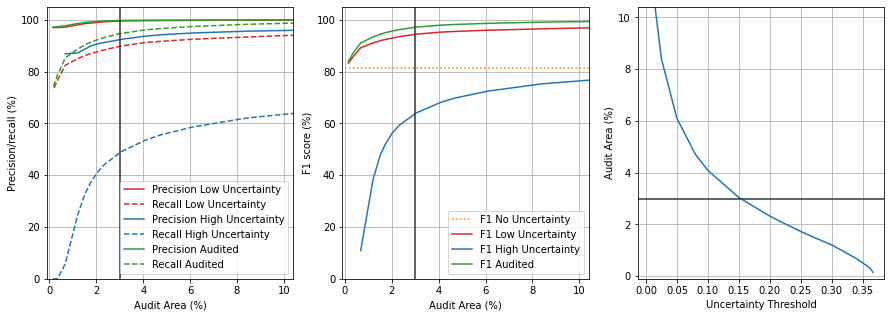

In [161]:
'''
xlim = [-0.3, 12.7]
xlim = [-0.1, 10.4]

ylim = [0, 105]
'''
manager.plotUncertaintyAA(normalize_xlim=False)

In [162]:
manager.dataset.paths.im_filenames[dates[1]][0]
manager.dataset.paths.optical_im_past_dates[dates[1]]

'D:/Jorge/datasets/sentinel2/PA/2019'

In [163]:
config['georreferenced_save'] = True

In [164]:
if config['georreferenced_save'] == True:
    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_uncertainty_georreferenced.tif'.format(
        manager.dataset.site)
    print("manager.uncertainty_to_show.shape", manager.uncertainty_to_show.shape)
    save_georreferenced(manager.uncertainty_to_show, original_im_path,produced_im_path)


manager.uncertainty_to_show.shape (17730, 9200)
im_pad.shape (17730, 9201)
im_pad.shape (1, 17730, 9201)


In [165]:
manager.predicted_unpad.shape

(17730, 9200)

In [166]:
'''
if config['georreferenced_save'] == True:
    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_uncertainty_georreferenced_jet.tif'.format(
        manager.dataset.site)

    jet_colormap_image = plt.get_cmap('jet')(manager.uncertainty_to_show)
    jet_colormap_image = (jet_colormap_image * 255).astype('uint8')
    # save_georreferenced(manager.uncertainty_to_show, original_im_path,produced_im_path)
'''

"\nif config['georreferenced_save'] == True:\n    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_uncertainty_georreferenced_jet.tif'.format(\n        manager.dataset.site)\n\n    jet_colormap_image = plt.get_cmap('jet')(manager.uncertainty_to_show)\n    jet_colormap_image = (jet_colormap_image * 255).astype('uint8')\n    # save_georreferenced(manager.uncertainty_to_show, original_im_path,produced_im_path)\n"

In [167]:
# jet_colormap_image.shape


In [168]:
# plt.imshow(jet_colormap_image[...,:-1])

In [169]:
if config['georreferenced_save'] == True:
    predicted_to_show = manager.predicted_unpad.copy()
    predicted_to_show[manager.label_mask == 2] = 0 # 1 for deforestation. 0 for the rest

    false_positive_mask = predicted_to_show - manager.label_mask_current_deforestation # 0 for correct. 1 for false positive. -1 for false negative
    false_positive_mask = (false_positive_mask + 1).astype(np.int8) # 1 for correct. 2 for false positive. 0 for false negative
    del predicted_to_show
    ic(np.unique(false_positive_mask, return_counts=True))

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_false_positive_mask_georreferenced.tif'.format(
        manager.dataset.site)
    print("false_positive_mask.shape", false_positive_mask.shape)
    save_georreferenced(false_positive_mask, original_im_path,produced_im_path)

    del false_positive_mask


ic| 2013903655.py:8 in <cell line: 1>()
    np.unique(false_positive_mask, return_counts=True): (array([0, 1, 2], dtype=int8),
                                                         array([   600092, 162427946,     87962], dtype=int64))


false_positive_mask.shape (17730, 9200)
im_pad.shape (17730, 9201)
im_pad.shape (1, 17730, 9201)


In [170]:
if config['georreferenced_save'] == True:
    predicted_georreferenced = manager.predicted_unpad.copy()
    predicted_georreferenced[manager.label_mask == 2] = 2 

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_predicted_georreferenced.tif'.format(
        manager.dataset.site)
    print("predicted_georreferenced.shape", predicted_georreferenced.shape)
    save_georreferenced(predicted_georreferenced, original_im_path,produced_im_path)
    del predicted_georreferenced


predicted_georreferenced.shape (17730, 9200)
im_pad.shape (17730, 9201)
im_pad.shape (1, 17730, 9201)
